Importing necessary libraries

In [39]:
import os
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as m_dates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

%matplotlib inline

Loading sample dataset for visualization

In [40]:
dataset = pd.read_csv(
    filepath_or_buffer='dataset/three_years/AAPL.csv', 
    index_col='Date')

dates_str = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dataset.index.values]

dataset.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449402,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314880,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970093,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200


Corelation between stock metrics

C:\Users\patro\AppData\Local\Temp\ipykernel_18104\395312540.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


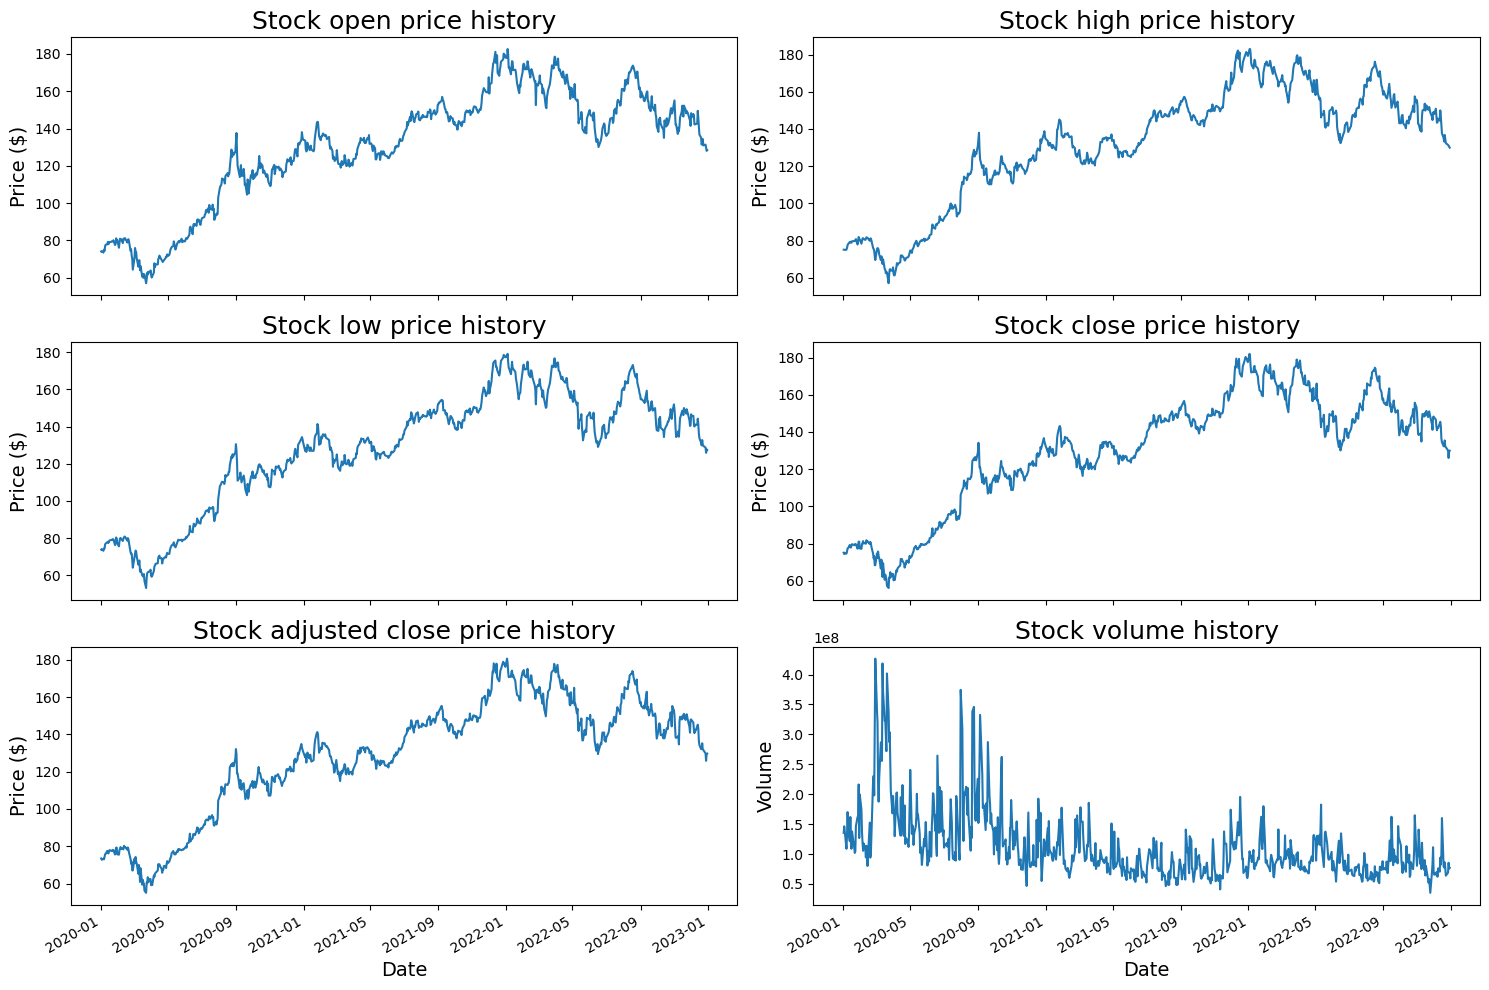

In [41]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

# Open price
plt.subplot(3, 2, 1)
plt.title('Stock open price history', fontsize=18)
plt.plot(dates_str, dataset['Open'])
plt.ylabel('Price ($)', fontsize=14)

# High price
plt.subplot(3, 2, 2)
plt.title('Stock high price history', fontsize=18)
plt.plot(dates_str, dataset['High'])
plt.ylabel('Price ($)', fontsize=14)

# low price
plt.subplot(3, 2, 3)
plt.title('Stock low price history', fontsize=18)
plt.plot(dates_str, dataset['Low'])
plt.ylabel('Price ($)', fontsize=14)

# Close price
plt.subplot(3, 2, 4)
plt.title('Stock close price history', fontsize=18)
plt.plot(dates_str, dataset['Close'])
plt.ylabel('Price ($)', fontsize=14)

# Adjusted close price
plt.subplot(3, 2, 5)
plt.title('Stock adjusted close price history', fontsize=18)
plt.plot(dates_str, dataset['Adj Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
# Volume
plt.subplot(3, 2, 6)
plt.title('Stock volume history', fontsize=18)
plt.plot(dates_str, dataset['Volume'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.gcf().autofmt_xdate()
plt.tight_layout()

EMA vs SMA

Moving average indicators are supposed to show trends in grow direction of price. Value is based on the previous intervals and because of it, has some delayed reaction to changes on the market. SMA tends to have lower sensitivity to changes and has more shift lags. According to this, traders tend to use EMA more than SMA.

Visualization of EMA and SMA short term indicators (26 days)

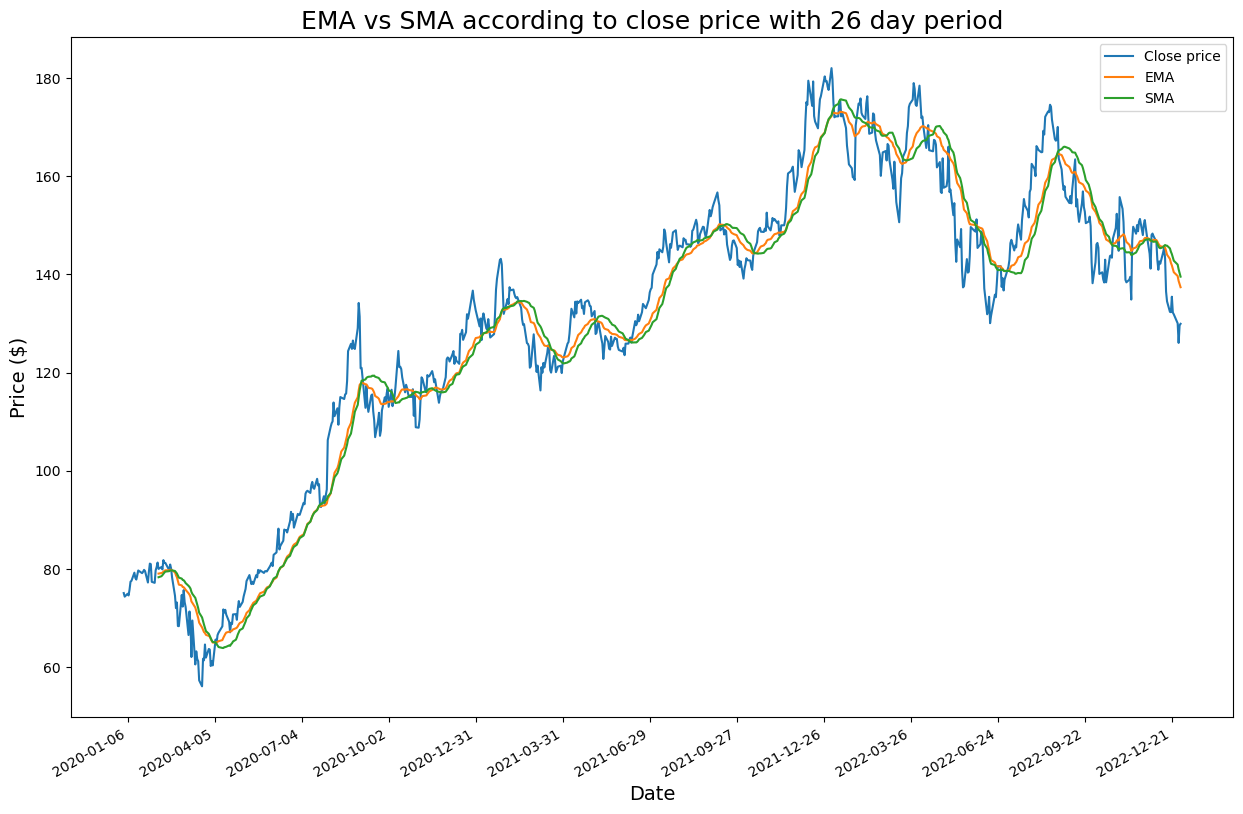

In [46]:
ema = dataset['Close'].ewm(span=26, min_periods=26).mean()
sma = dataset['Close'].rolling(26).mean()

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('EMA vs SMA according to close price with 26 day period', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.plot(dates_str, ema, label='EMA')
plt.plot(dates_str, sma, label='SMA')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Comparing EMA with different periods

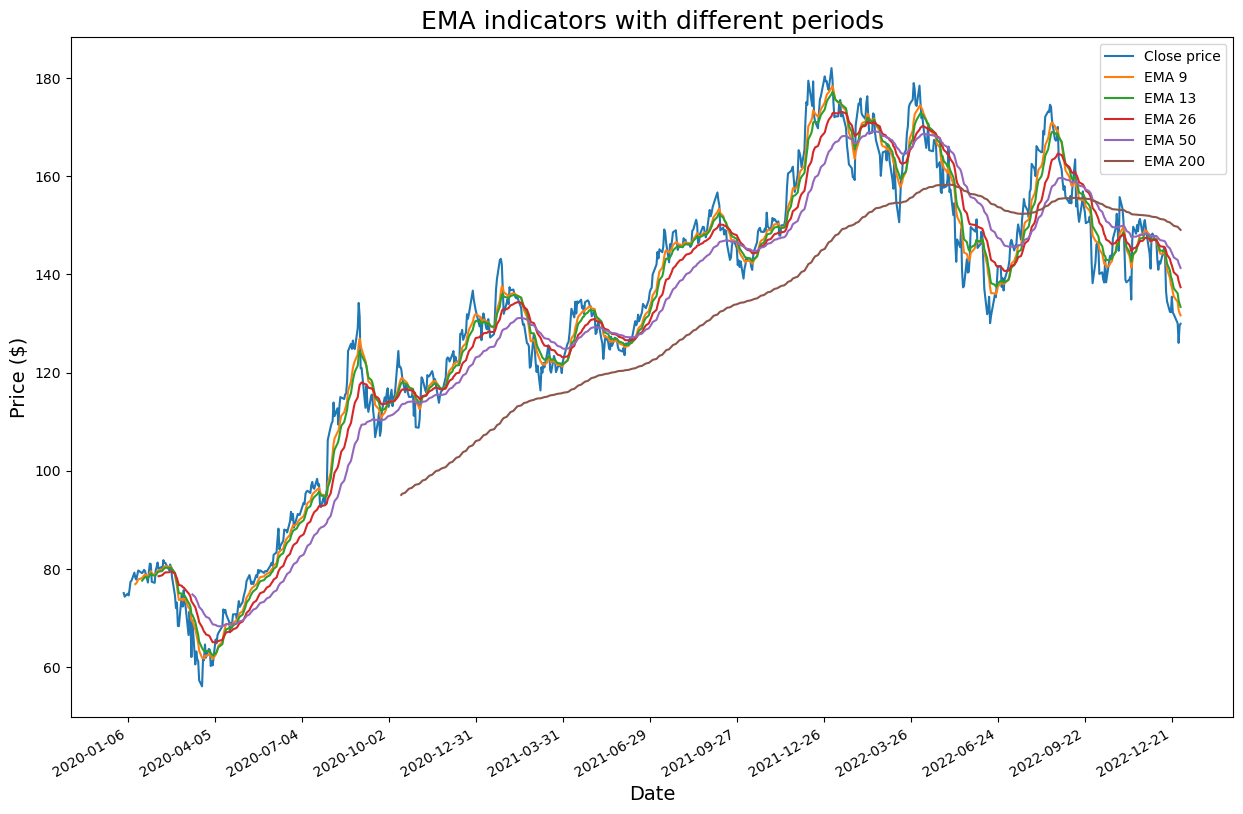

In [43]:
ema_9 = dataset['Close'].ewm(span=9, min_periods=9, adjust=False).mean()
ema_13 = dataset['Close'].ewm(span=13, min_periods=13, adjust=False).mean()
ema_26 = dataset['Close'].ewm(span=26, min_periods=26, adjust=False).mean()
ema_50 = dataset['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
ema_200 = dataset['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.title('EMA indicators with different periods', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.plot(dates_str, ema_9, label='EMA 9')
plt.plot(dates_str, ema_13, label='EMA 13')
plt.plot(dates_str, ema_26, label='EMA 26')
plt.plot(dates_str, ema_50, label='EMA 50')
plt.plot(dates_str, ema_200, label='EMA 200')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Moving Average Convergence Divergence (MACD) is one of the most popular technical indicators used to generate signals to buy or sell shares wherease the value of the difference indicator stays above or under the value of 0.

To create MACD we need to implement three "signals". 

First one, mostly known as MACD represents substracted value of EMA with long lookback period from EMA with short lookback period. In our example it's EMA 13 and EMA 26.
Second one is trigger signal which is respresented by EMA with shorter lookback period than the one used in MACD signal. Typically it's EMA 9.
The last one is difference signal which is basically subtracted value of trigger signal from the MACD signal.

Visualization of MACD

C:\Users\patro\AppData\Local\Temp\ipykernel_18104\1444963542.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


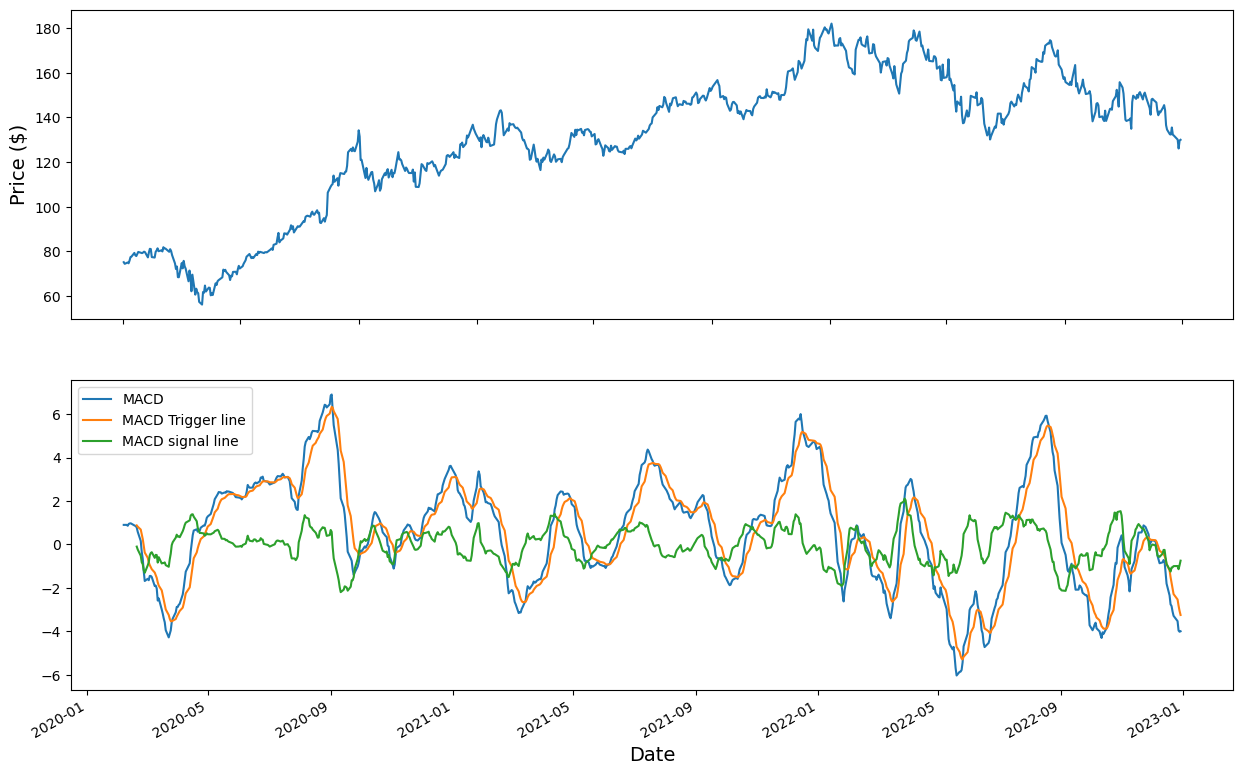

In [44]:
macd = ema_13 - ema_26
macd_trigger = macd.ewm(span=9, min_periods=9, adjust=False).mean()
macd_difference = macd - macd_trigger

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))
plt.title('MACD', fontsize=18)

plt.subplot(2, 1, 1)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.ylabel('Price ($)', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(dates_str, macd, label='MACD')
plt.plot(dates_str, macd_trigger, label='MACD Trigger line')
plt.plot(dates_str, macd_difference, label='MACD signal line')

plt.xlabel('Date', fontsize=14)
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

Relative Strength Index is a momentum indicator that represents magnitude of recent price changes. 
It's mostly known for evaluation of either overbought or oversold conditions of shares.
It takes value from 0 to 100. 
For indication of overbought or oversold signals mostly common trend lines take values of 60/40 or 70/30. Depending on intentions of the trader. One gives more opportunities but with less presumable profit and other gives less opportunities but with more likely profit.

Visualization of RSI

C:\Users\patro\AppData\Local\Temp\ipykernel_18104\1267040693.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


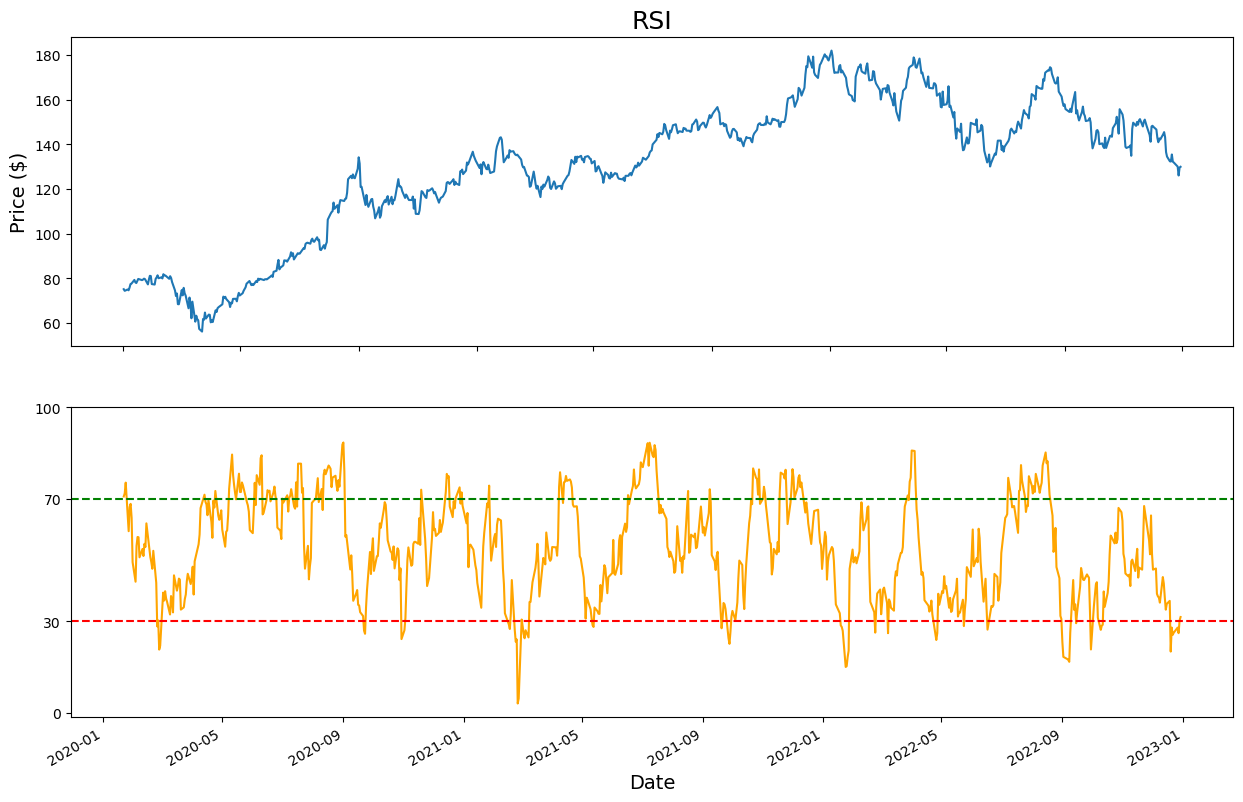

In [45]:
delta = dataset['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean().abs()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(m_dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(m_dates.DayLocator(interval=90))

plt.subplot(2, 1, 1)
plt.title('RSI', fontsize=18)
plt.plot(dates_str, dataset['Close'], label='Close price')
plt.ylabel('Price ($)', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(dates_str, rsi, label='RSI', color='orange')
plt.axhline(y=30, color='red', linestyle='--')
plt.axhline(y=70, color='green', linestyle='--')
plt.yticks([0, 30, 70, 100])

plt.xlabel('Date', fontsize=14)
plt.gcf().autofmt_xdate()

plt.show()